In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from theano import shared
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

## Simple Linear Regression

In [3]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N) # noise 발생

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

데이터 생성

C:\Users\User\AppData\Local\Temp\ipykernel_12944\105062528.py:8: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


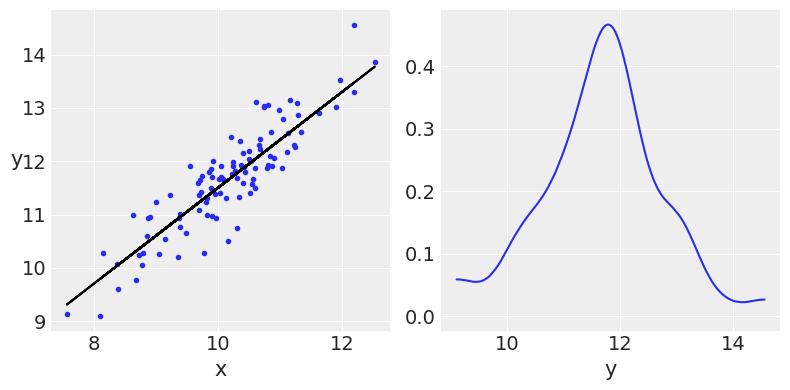

In [4]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

In [5]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_g = pm.sample(2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 60 seconds.
The acceptance probability does not match the target. It is 0.8843083587926316, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8979453104005626, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

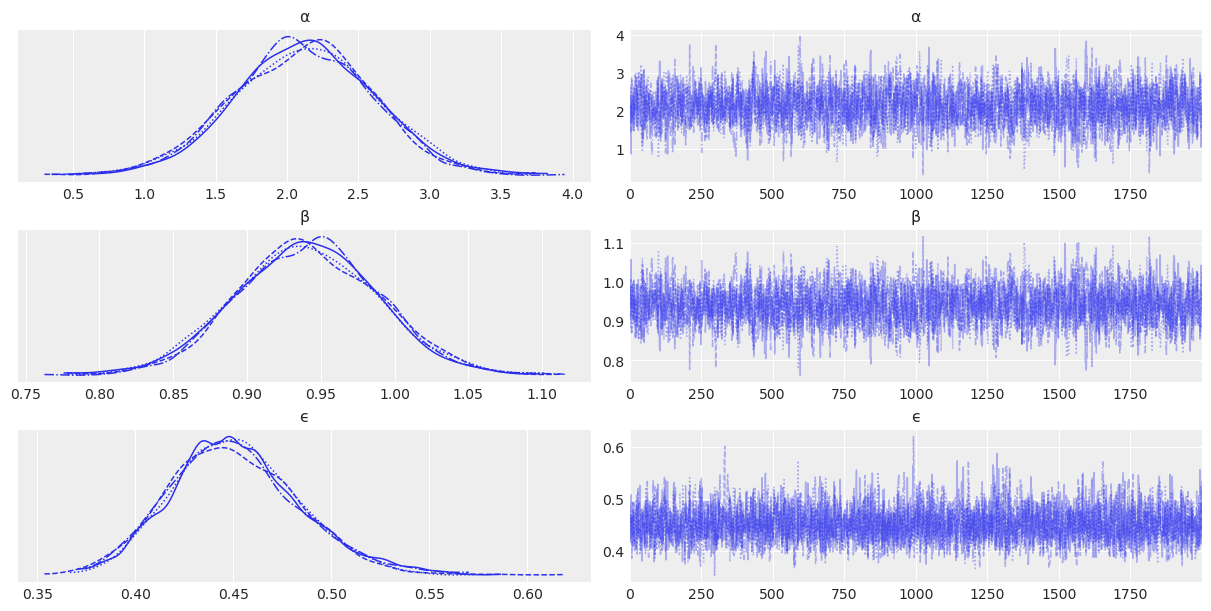

In [6]:
az.plot_trace(idata_g, var_names=['α', 'β', 'ϵ'])

C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\pairplot.py:186: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


<AxesSubplot:xlabel='α', ylabel='β'>

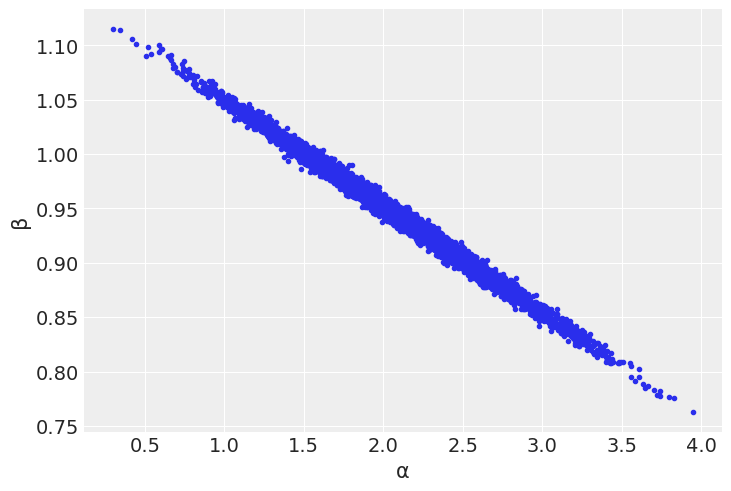

In [7]:
az.plot_pair(idata_g, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})

즉 다음 plot을 해석하자면, 확률적 모형으로 선형회귀를 진행할경우 intercept와 coefficient는 trade-off 관계가 있다는 것을 알 수 있다.

## Posterior 해석하기

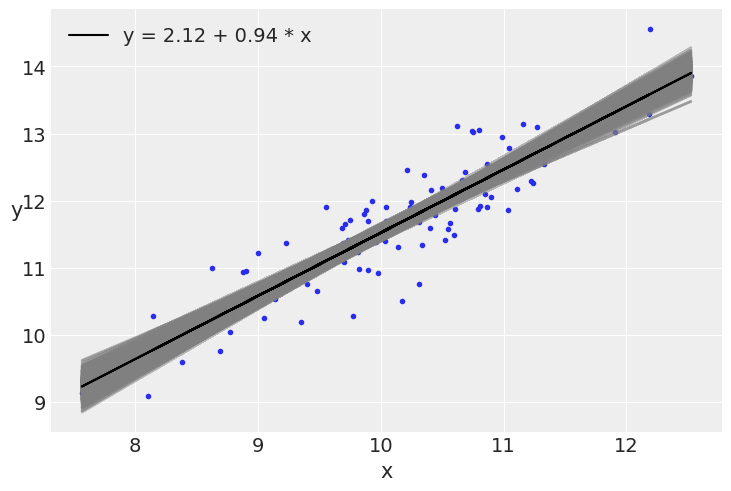

In [8]:
plt.plot(x, y, 'C0.')

posterior_g = idata_g.posterior.stack(samples={"chain", "draw"})
alpha_m = posterior_g['α'].mean().item()
beta_m = posterior_g['β'].mean().item()

draws = range(0, posterior_g.samples.size, 10)
plt.plot(x, posterior_g['α'][draws].values + posterior_g['β'][draws].values * x[:,None], c='gray', alpha=0.5)
# 회색 형태로 시행에 따른 직선들 그림
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


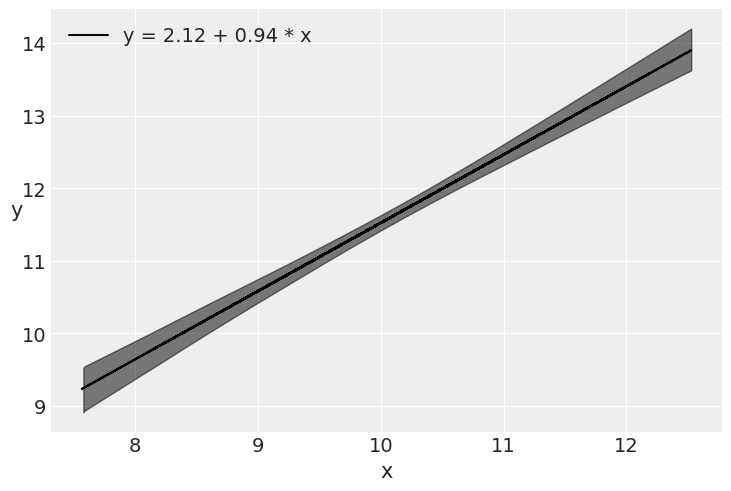

In [9]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

sig = az.plot_hdi(x, posterior_g['μ'].T, hdi_prob=0.98, color='k')
# 즉 회색 영역 안에 직선식이 존재할 확률이 98%이다.
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

In [10]:
ppc = pm.sample_posterior_predictive(idata_g, samples=2000, model=model_g)

C:\Anaconda3\envs\pymc_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'y')

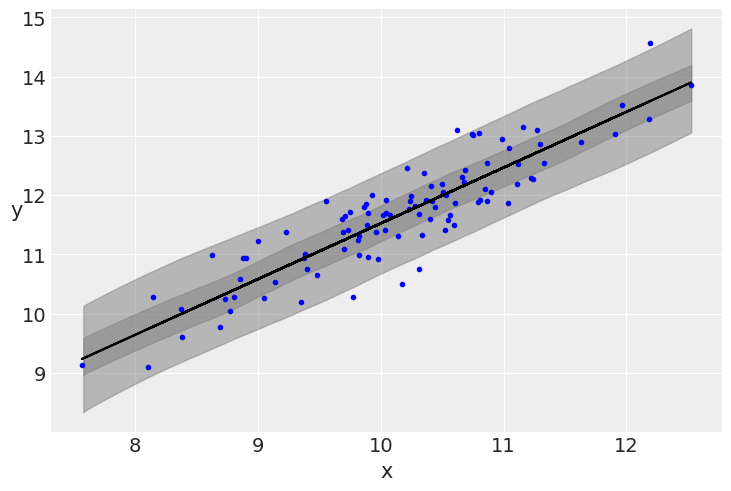

In [11]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hdi(x, ppc['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(x, ppc['y_pred'], color='gray')

plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [12]:
az.r2_score(y, ppc['y_pred'])

r2        0.785473
r2_std    0.006080
dtype: float64

## 다변량 Normal Distribution

Text(-0.05, 0.5, 'x_2')

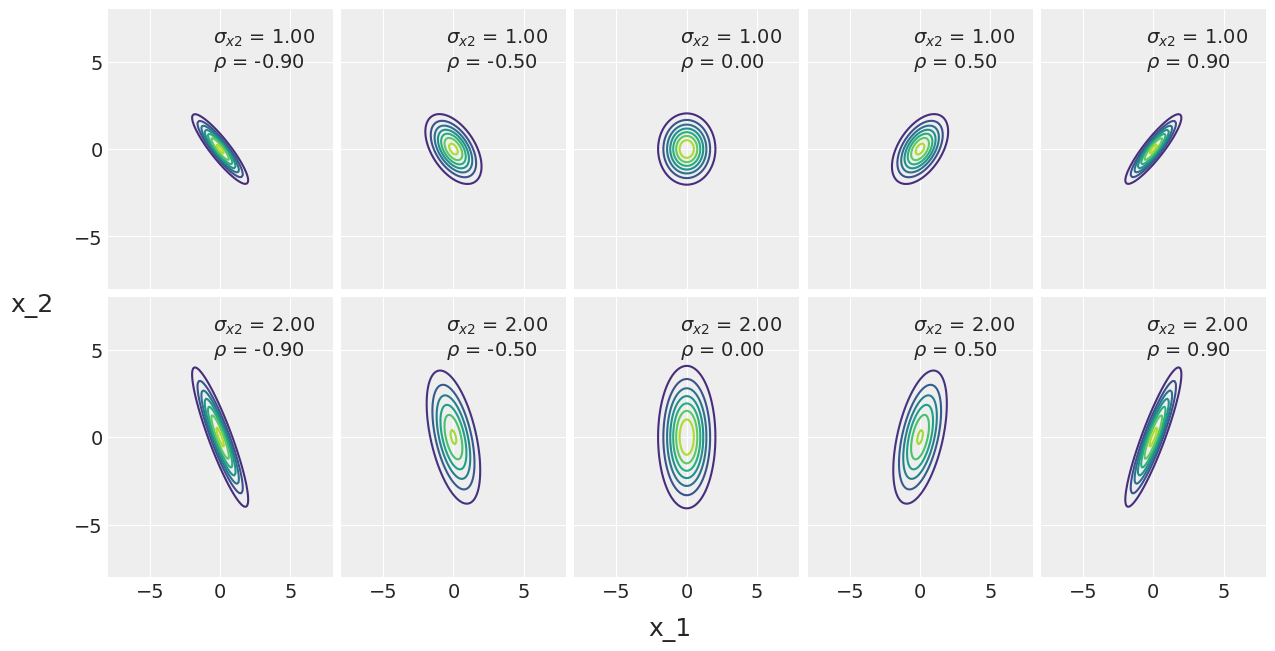

In [13]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.90, -0.5, 0, 0.5, 0.90]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k
pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos),
                     sharex=True, sharey=True, figsize=(12, 6),
                     constrained_layout=True)
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
               [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i, j].contour(k, l, rv.pdf(pos))
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(0, 0,
                      label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
        ax[i, j].legend()
f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)

In [14]:
data = np.stack((x, y)).T
with pm.Model() as pearson_model:

    μ = pm.Normal('μ', mu=data.mean(0), sd=10, shape=2)

    σ_1 = pm.HalfNormal('σ_1', 10)
    σ_2 = pm.HalfNormal('σ_2', 10)
    ρ = pm.Uniform('ρ', -1., 1.)
    r2 = pm.Deterministic('r2', ρ**2) # 확률분포가 아닌 결정된 값.

    cov = pm.math.stack(([σ_1**2, σ_1*σ_2*ρ],
                         [σ_1*σ_2*ρ, σ_2**2]))

    y_pred = pm.MvNormal('y_pred', mu=μ, cov=cov, observed=data)
    # 다변량 정규분포를 다루기 위함. Covriance Matrix와 prior 입력받음.
    idata_p = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ρ, σ_2, σ_1, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
The acceptance probability does not match the target. It is 0.8803973824063485, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'r2'}>,
        <AxesSubplot:title={'center':'r2'}>]], dtype=object)

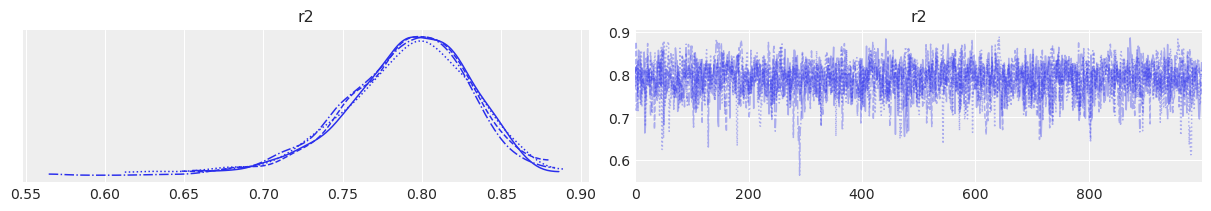

In [15]:
az.plot_trace(idata_p, var_names=['r2'])

In [16]:
az.summary(idata_p, var_names=['r2'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r2,0.79,0.04,0.718,0.865,0.001,0.001,2023.0,1947.0,1.0


## Robust Linear Regression

앞의 챕터에서는 Gaussian 분포를 이용하여 Linear Regression 모델을 이용하여 coefficient 및 bias에 대한 분포를 얻었는데, 이번에는 조금 더 robust 한 Student-t분포를 이용하여 회귀를 할 예정이다.  
Student-t분포 특징때문에 Outlier가 있어도 조금 더 robust 한 것이 장점이다.

In [17]:
ans = pd.read_csv('./data/anscombe.csv')
ans.head()

,group,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33


In [18]:
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

C:\Users\User\AppData\Local\Temp\ipykernel_12944\3152834436.py:12: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


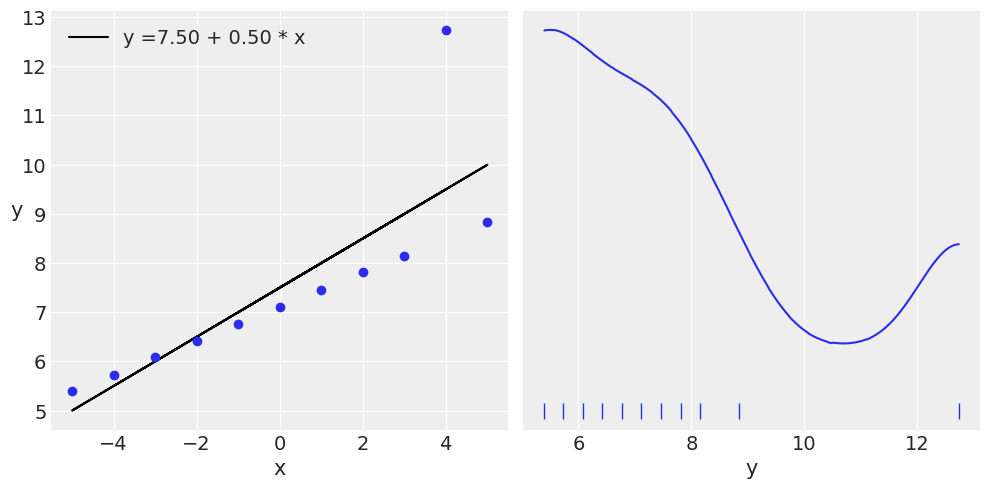

In [19]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()

In [20]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν, observed=y_3)

    idata_t = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.
The number of effective samples is smaller than 10% for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>],
       [<AxesSubplot:title={'center':'ν'}>,
        <AxesSubplot:title={'center':'ν'}>]], dtype=object)

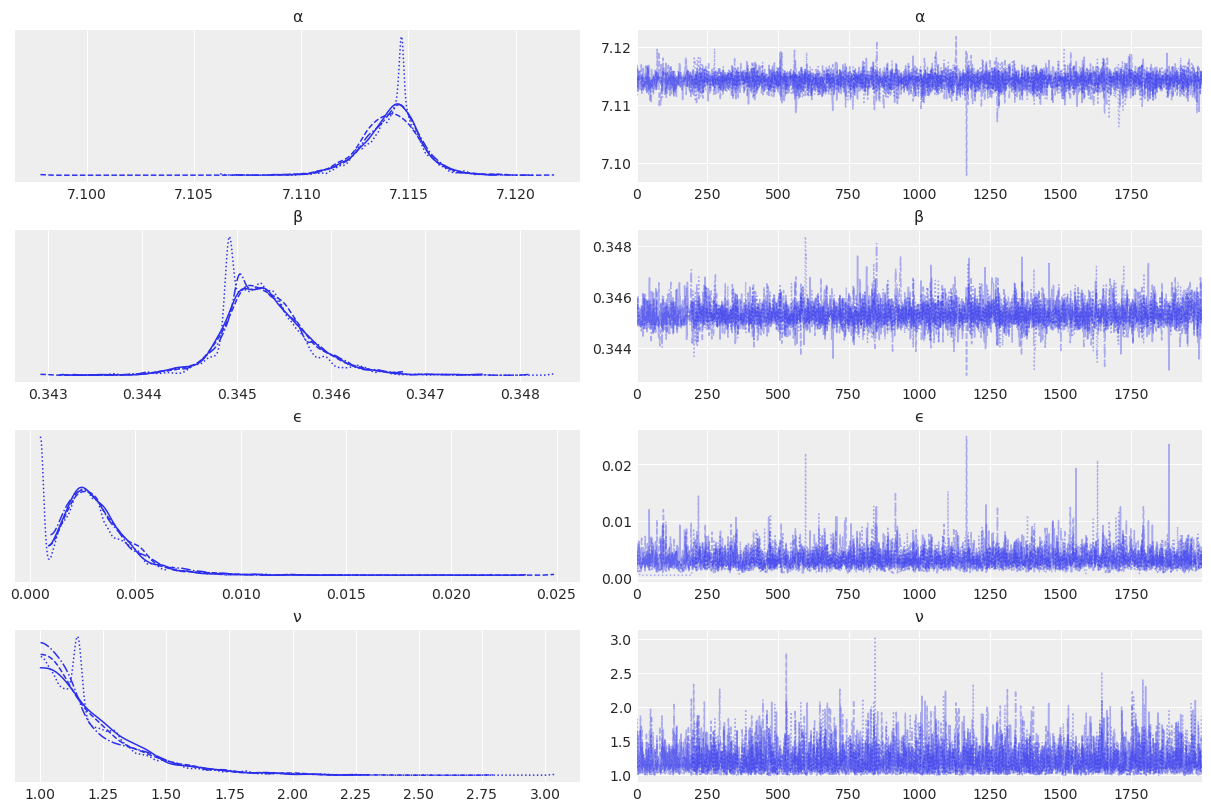

In [21]:
varnames = ['α', 'β', 'ϵ', 'ν']
az.plot_trace(idata_t, var_names=varnames)

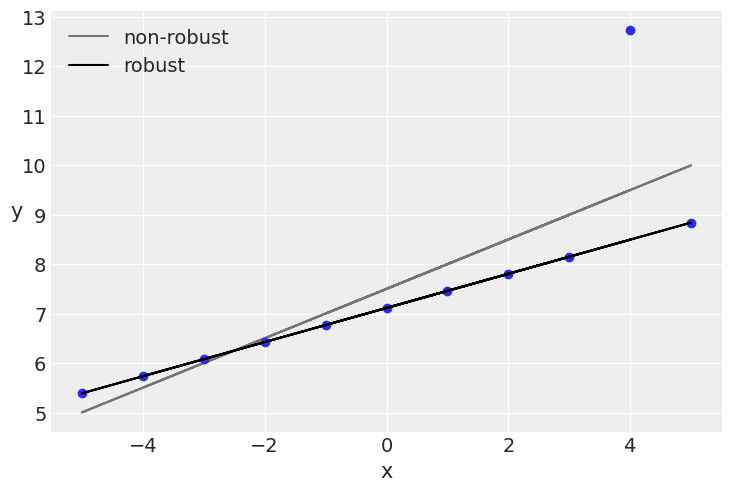

In [22]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = idata_t.posterior['α'].mean().item()
beta_m = idata_t.posterior['β'].mean().item()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)

즉 outlier가 있어도, robust의 경우 예측을 정말 잘한다. non-robust의 경우 outlier에 의해 선이 많이 달라졌다.

In [23]:
az.summary(idata_t, var_names=varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,7.114,0.001,7.112,7.117,0.000,0.000,4543.0,4110.0,1.00
β,0.345,0.000,0.345,0.346,0.000,0.000,2299.0,3606.0,1.00
ϵ,0.003,0.002,0.000,0.006,0.000,0.000,306.0,61.0,1.01
ν,1.211,0.200,1.000,1.577,0.003,0.002,3320.0,2396.0,1.01


In [24]:
ppc = pm.sample_posterior_predictive(idata_t, model=model_t, random_seed=2, keep_size=True)

(0.0, 12.0)

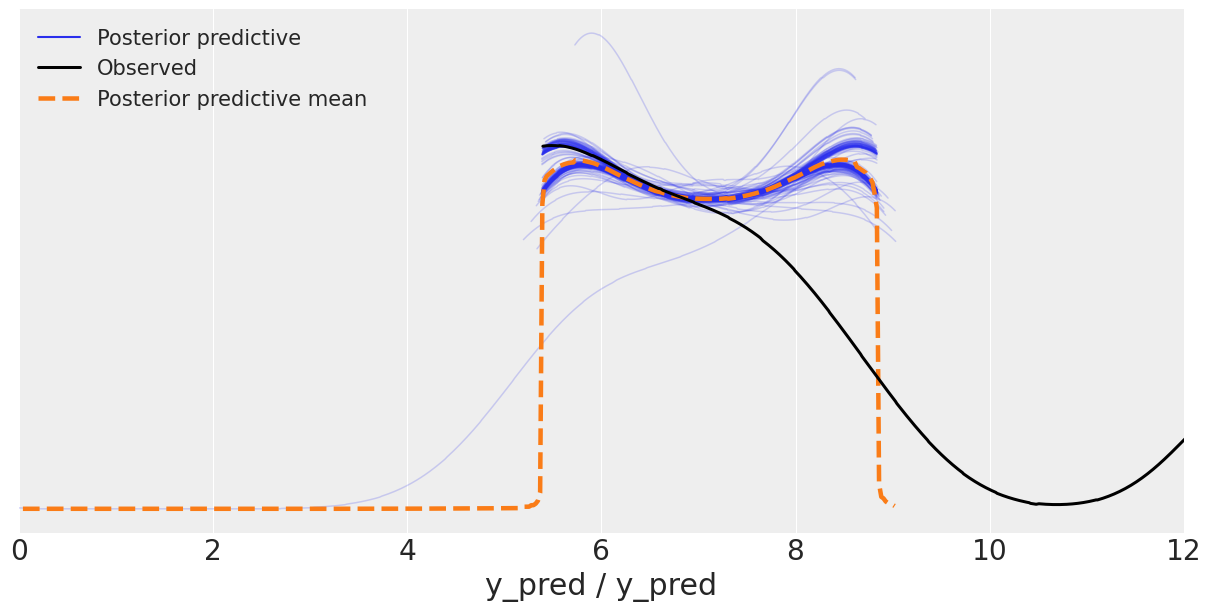

In [25]:
az.concat(idata_t, az.from_dict(posterior_predictive=ppc), inplace=True)
ax = az.plot_ppc(idata_t, num_pp_samples=200, figsize=(12, 6), mean=True)
plt.xlim(0, 12)

## Hierarchical Linear Regresson

앞서 다룬 Hierarchical 분포를 이용하여 Linear Regression 이용해보기  
Hierarchical 분포를 이용할 경우 hyperparameter 분포를 이용하여 새로운 분포를 만들고, 그 분포들에 의해 값이 결정된다.

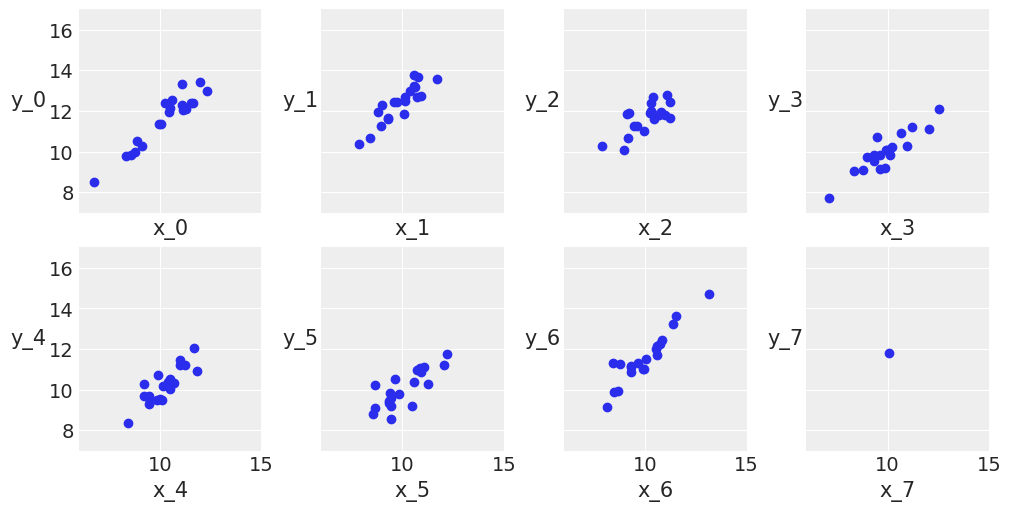

In [26]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N

In [27]:
x_centered = x_m - x_m.mean()

In [28]:
with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())

    idata_up = pm.sample(2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

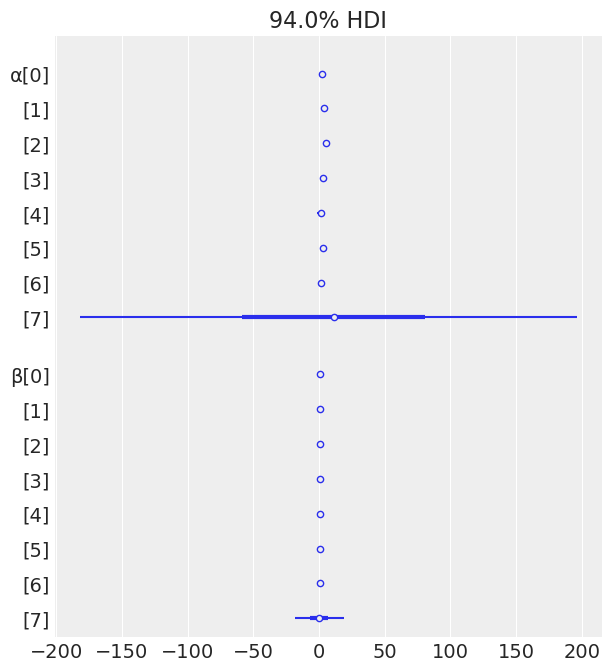

In [29]:
az.plot_forest(idata_up, var_names=['α', 'β'], combined=True)

다른 데이터와 다르게 x_7, y_7은 하나로 결정되어 있어 계수의 분포가 매우매우 넓다.  
따라서 어느정도 2개의 점 정도는 주어야 정확한 추정이 가능하다  
그러나 alpha에 대해 강한 prior를 줄 경우 분포를 어느정도 잘 추정가능하다

In [30]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    idata_hm = pm.sample(2000, target_accept=0.99, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 103 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9666320920896972, but should be close to 0.99. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 249 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8473268027189725, but should be close to 0.99. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

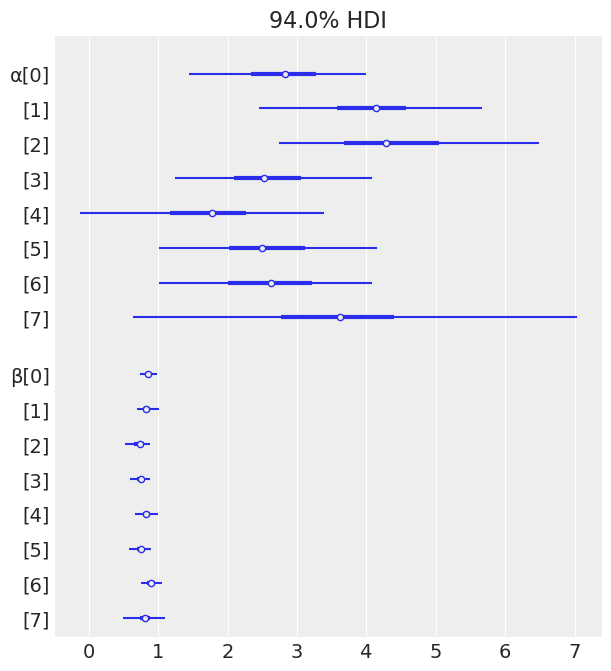

In [31]:
az.plot_forest(idata_hm, var_names=['α', 'β'], combined=True)

C:\Users\User\AppData\Local\Temp\ipykernel_12944\3701480557.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


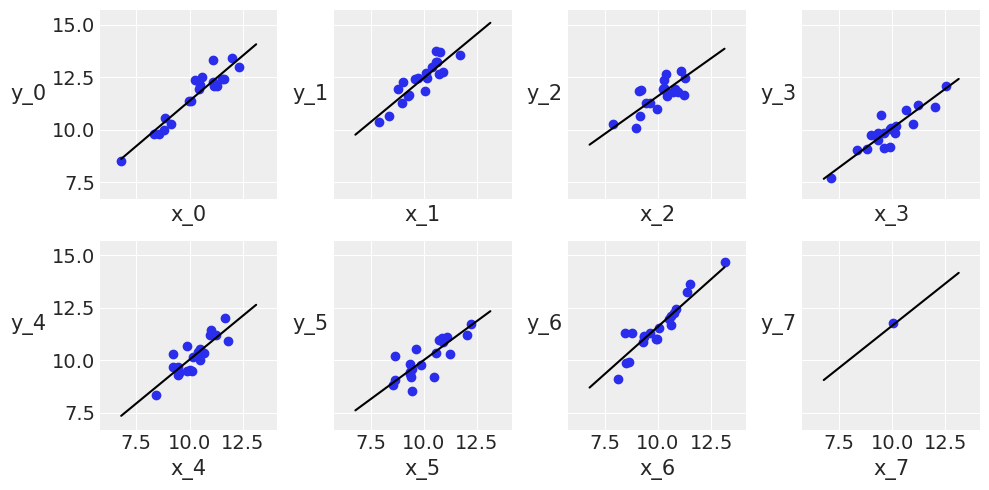

In [32]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)

posterior_hm = idata_hm.posterior.stack(samples={"chain", "draw"})

for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = posterior_hm["α"].sel({"α_dim_0":i}).mean().item()
    beta_m = posterior_hm["β"].sel({"β_dim_0":i}).mean().item()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.tight_layout()

즉 hyper-prior를 통해 hierarchical distribution 이용시 점 형태의 데이터에 대해서도 fit 가능

## Polynomial Regression

회귀의 차수를 높여 다항식을 이용한 비선형 회귀

Text(0, 0.5, 'y')

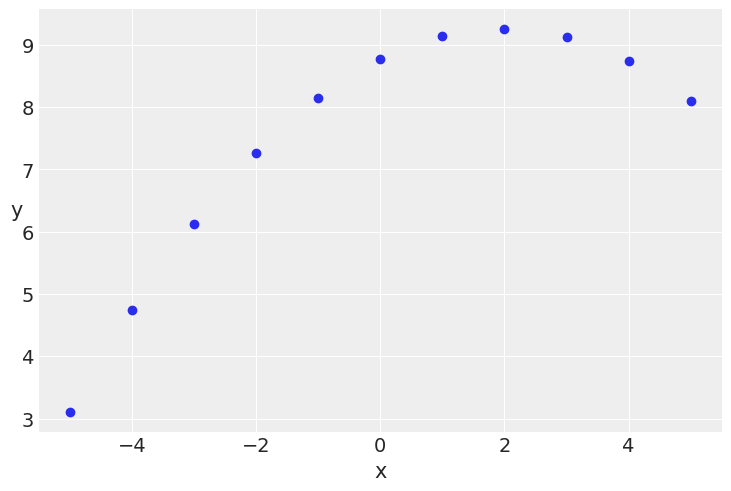

In [33]:
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [34]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_2.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    mu = α + β1 * x_2 + β2 * x_2**2

    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_2)

    idata_poly = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β1'}>,
        <AxesSubplot:title={'center':'β1'}>],
       [<AxesSubplot:title={'center':'β2'}>,
        <AxesSubplot:title={'center':'β2'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

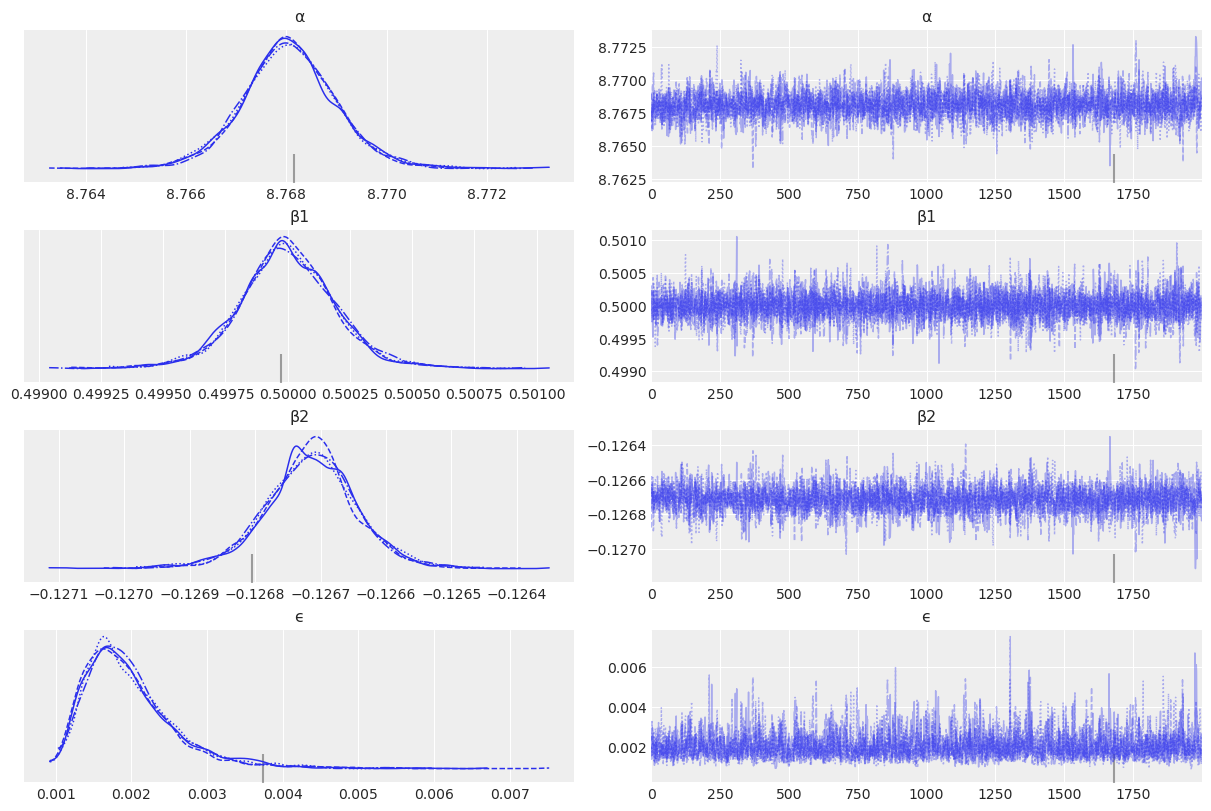

In [35]:
az.plot_trace(idata_poly)

In [36]:
az.summary(idata_poly)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,8.768,0.001,8.766,8.770,0.0,0.0,3268.0,3412.0,1.0
β1,0.500,0.000,0.500,0.500,0.0,0.0,4848.0,3781.0,1.0
β2,-0.127,0.000,-0.127,-0.127,0.0,0.0,3336.0,3409.0,1.0
ϵ,0.002,0.001,0.001,0.003,0.0,0.0,2378.0,2470.0,1.0


In [37]:
idata_poly.posterior['α'].mean()

<xarray.DataArray 'α' ()>
array(8.76806373)

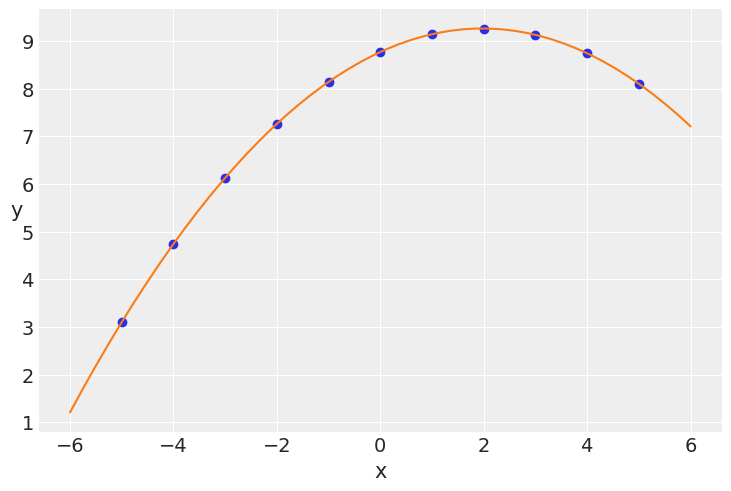

In [38]:
x_p = np.linspace(-6, 6)
y_p = idata_poly.posterior['α'].mean().item() + idata_poly.posterior['β1'].mean().item() * \
    x_p + idata_poly.posterior['β2'].mean().item() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')

그러나 다항회귀의 경우 overfitting 문제가 존재

## Multiple Linear Regression

In [39]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

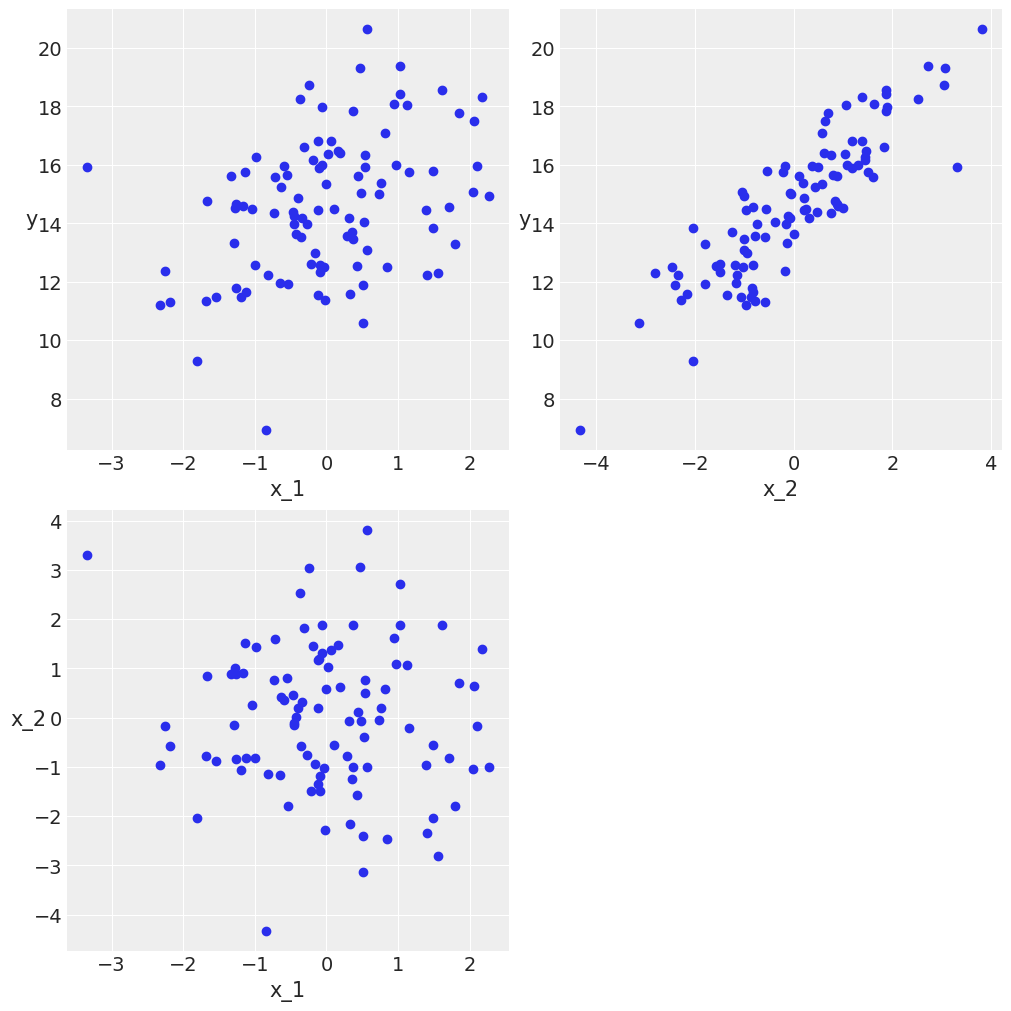

In [40]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

scatter_plot(X_centered, y)

In [41]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α_tmp + pm.math.dot(X_centered, β)

    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_mlr = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α_tmp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

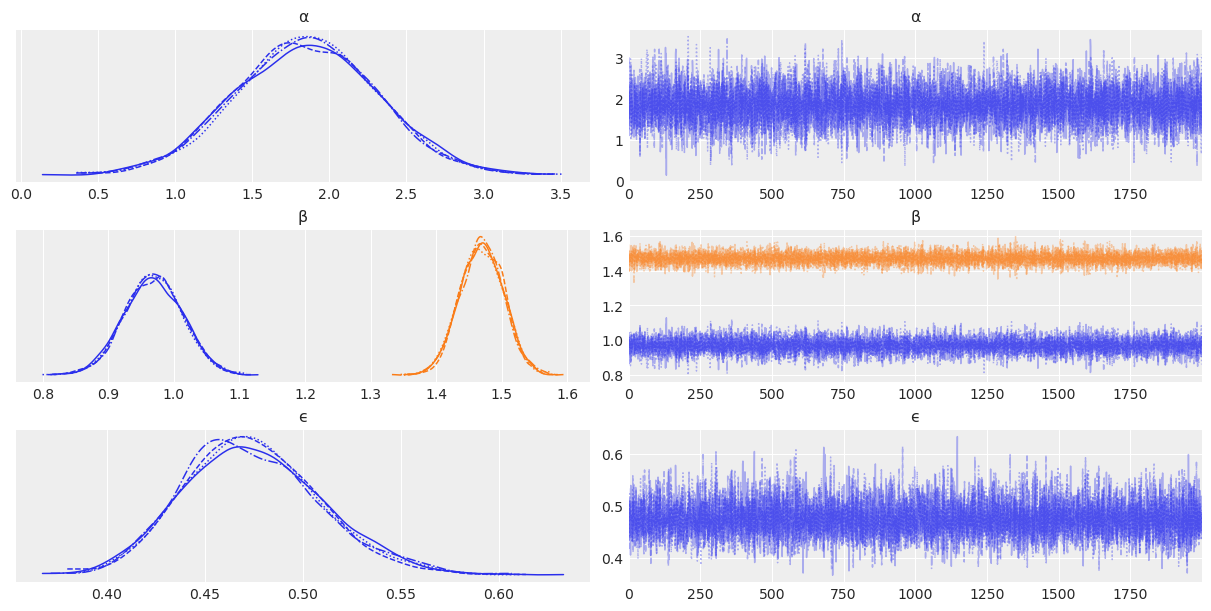

In [42]:
varnames = ['α', 'β', 'ϵ']
az.plot_trace(idata_mlr, var_names=varnames)

In [43]:
az.summary(idata_mlr, var_names=varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],1.852,0.460,0.981,2.702,0.004,0.003,11484.0,5902.0,1.0
β[0],0.969,0.044,0.889,1.055,0.000,0.000,11783.0,6139.0,1.0
β[1],1.470,0.033,1.408,1.530,0.000,0.000,12418.0,6075.0,1.0
ϵ,0.474,0.035,0.409,0.540,0.000,0.000,11941.0,5854.0,1.0


## Confounding variables and redundant variables

In [44]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T
# 변수 생성

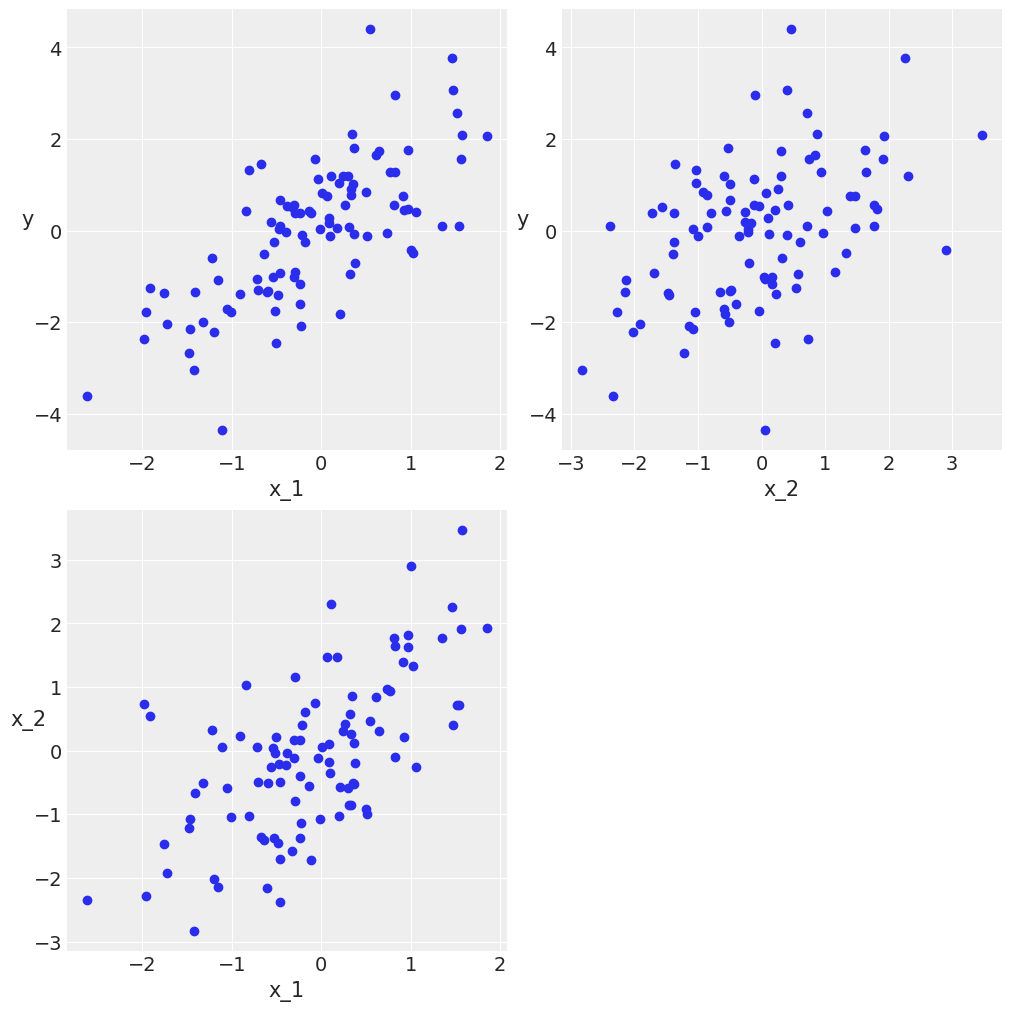

In [45]:
scatter_plot(X, y)

x_1, x_2, 그리고 x_1, x_2 둘다 사용하는 선형회귀 모델 만들기

In [46]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_x1x2 = pm.sample(2000, return_inferencedata=True)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_x1 = pm.sample(2000, return_inferencedata=True)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_x2 = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

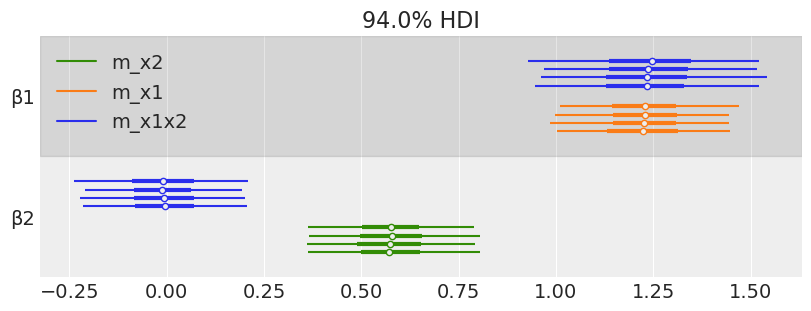

In [47]:
az.plot_forest([idata_x1x2, idata_x1, idata_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=False, colors='cycle', figsize=(8, 3))

계수를 비교해보면, 두 변수 다 활용할때와 하나의 변수만을 비교한 계수를 비교할 경우 m_x1, m_x1x2의 계수는 둘다 비슷하다.  
따라서 정보가 유의미하다고 볼 수 있다.  
그러나 x_2의 계수는 다변량 모델의 경우 0 언저리 이나 x_2만을 학습에 이용하였을때 무려 0.55 이다.  
즉 이로인해 x1이 주어질 경우 추가로 x_2를 주어지는 것이 정말 쓸모없다는 것을 알 수 있다.  
이러한 x_2같은 변수를 redundant variable이라고 한다.

In [48]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

앞선 경우와 다르게 scale=0.01 이여서 x_1, x_2 비교해보면 거의 일치를 한다.

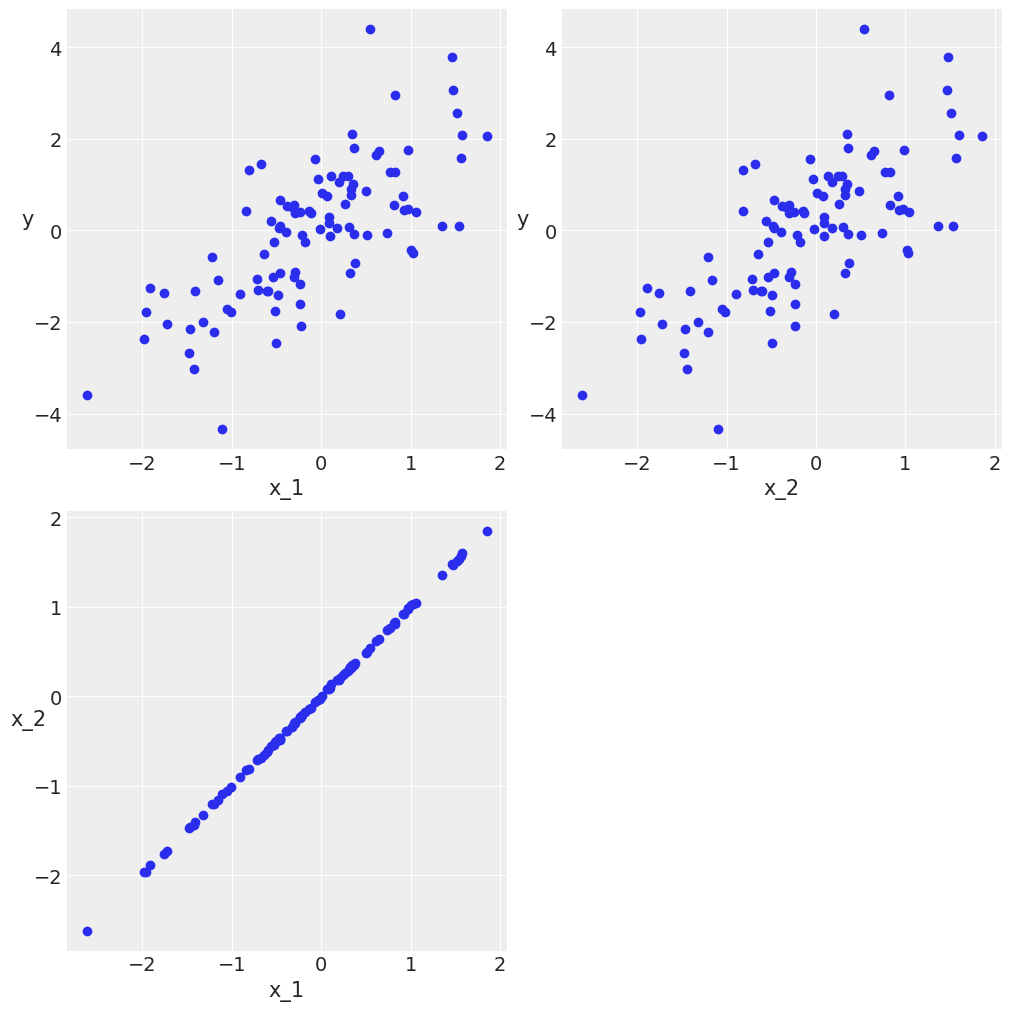

In [49]:
scatter_plot(X, y)

In [50]:
with pm.Model() as model_red:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + pm.math.dot(X, β)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_red = pm.sample(2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 153 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

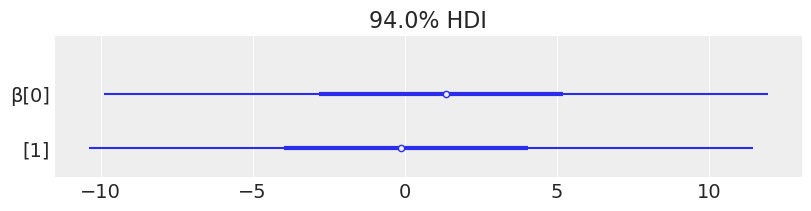

In [51]:
az.plot_forest(idata_red, var_names=['β'], combined=True, figsize=(8, 2))

<AxesSubplot:xlabel='β\n0', ylabel='β\n1'>

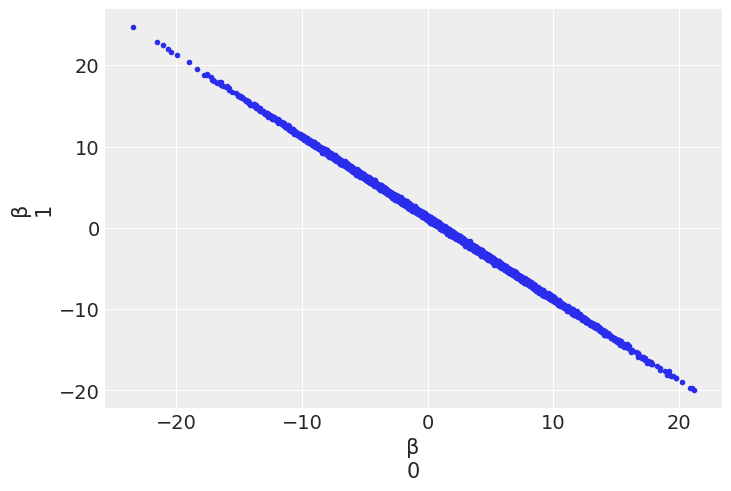

In [52]:
az.plot_pair(idata_red, var_names=['β'])

x_1, x_2가 거의 동일하므로, 하나의 beta가 올라가면 다른 beta가 줄어든다.  
따라서 원래는 모델링을 할때 $\mu = \alpha + \beta_1x_1 + \beta_2x_2$로 가정하였으나, beta들의 관계를 볼때 beta_1 + beta_2가 일정하여 $\beta = \alpha + (\beta_1 + \beta_2)x $ 로 모델링을 할 수 있다.

즉 다음과 같이 일어나는 원인은 두 변수끼리 상관관계가 상당해서 일어나는데, 보통 상관계수가 0.9 이상이면 어느정도 Baeysian 모델을 만들고나서 문제가 발생한다.  
이것을 해소하기 위한 방법으론  
1. 하나의 변수를 제거  
2. PCA  
3. Regularizing Prior 가 있다.

## Masking effect variables

toy 데이터 생성

In [53]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T

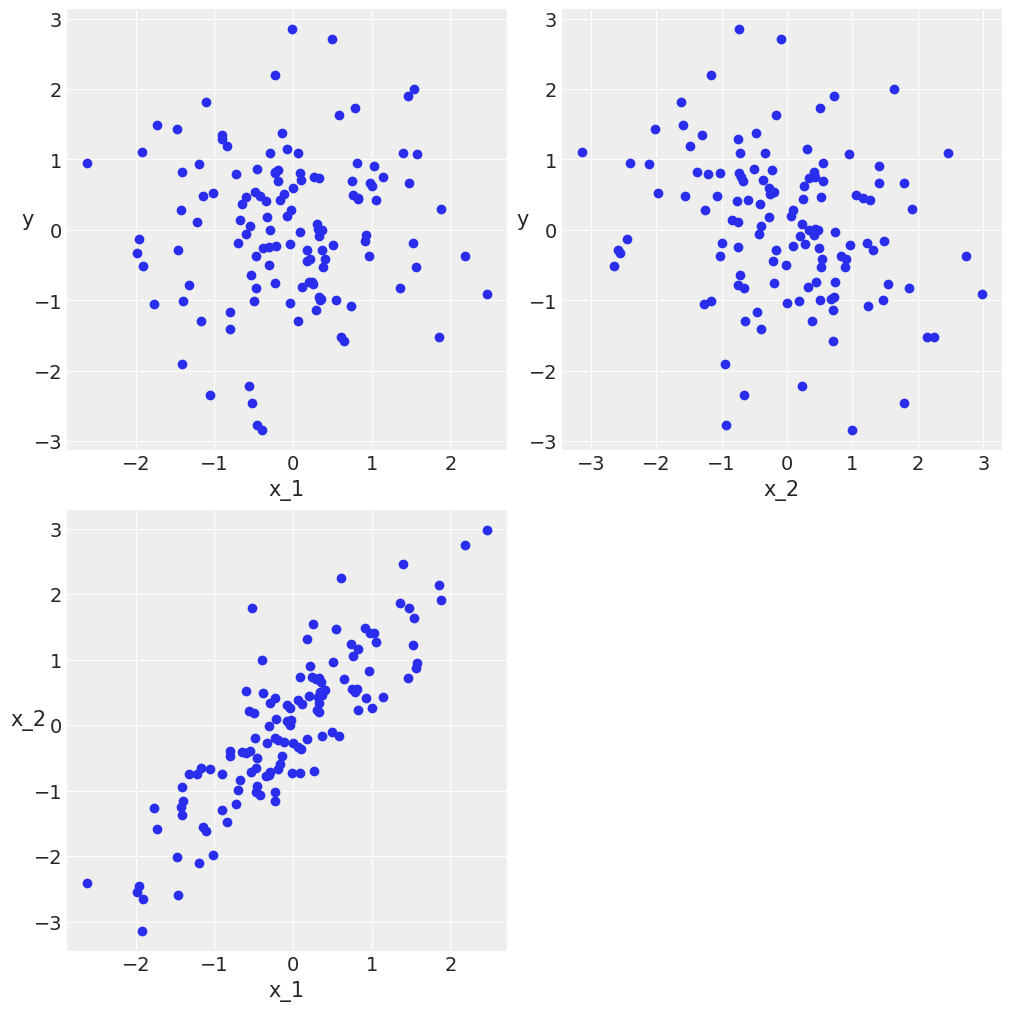

In [54]:
scatter_plot(X, y)

In [55]:
with pm.Model() as m_x1x2:# x1, x2 둘다 이용
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_x1x2 = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


In [56]:
with pm.Model() as m_x1:# x1만 이용
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_x1 = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β1, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


In [57]:
with pm.Model() as m_x2:#x2만 이용
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_x2 = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

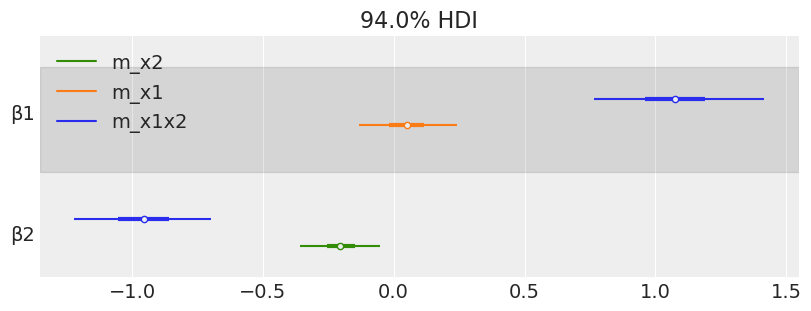

In [58]:
az.plot_forest([idata_x1x2, idata_x1, idata_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=True, colors='cycle', figsize=(8, 3))

plot_foreset 결과를 보면 x1만 이용할때가 hdi 간격이 좁으므로, x2는 별다른 영향을 안준다고 해석을 할 수 있다.

## Variable variance

<AxesSubplot:xlabel='Month', ylabel='Lenght'>

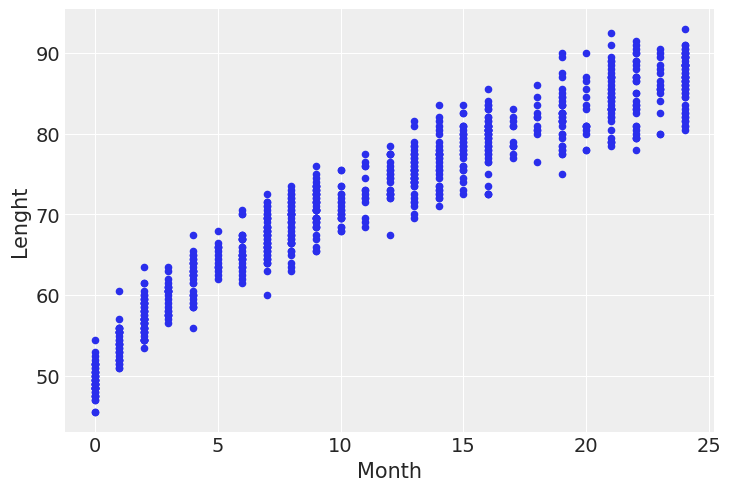

In [59]:
data = pd.read_csv('data/babies.csv')
data.plot.scatter('Month', 'Lenght')

In [60]:
with pm.Model() as model_vv:
    α = pm.Normal('α', sd=10)
    β = pm.Normal('β', sd=10)
    γ = pm.HalfNormal('γ', sd=10)
    δ = pm.HalfNormal('δ', sd=10)

    x_shared = shared(data.Month.values * 1.)

    μ = pm.Deterministic('μ', α + β * x_shared**0.5)
    ϵ = pm.Deterministic('ϵ', γ + δ * x_shared)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=data.Lenght)

    idata_vv = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [δ, γ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
The acceptance probability does not match the target. It is 0.8876767877820575, but should be close to 0.8. Try to increase the number of tuning steps.


Text(0, 0.5, 'y')

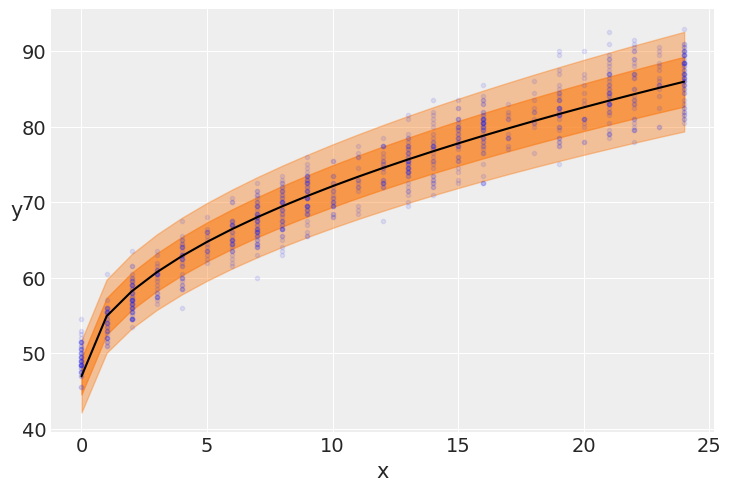

In [61]:
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.1)

μ_m = idata_vv.posterior['μ'].mean(("chain", "draw")).values
ϵ_m = idata_vv.posterior['ϵ'].mean(("chain", "draw")).values

plt.plot(data.Month, μ_m, c='k')
plt.fill_between(data.Month,
                 μ_m + 1 * ϵ_m, μ_m - 1 * ϵ_m,
                 alpha=0.6, color='C1')
plt.fill_between(data.Month,
                 μ_m + 2 * ϵ_m, μ_m -2 * ϵ_m,
                 alpha=0.4, color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [62]:
x_shared.set_value([0.5])
ppc = pm.sample_posterior_predictive(idata_vv, 2000, model=model_vv)
y_ppc = ppc['y_pred'][:, 0]

C:\Anaconda3\envs\pymc_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


sample_posterior_predictive의 경우 output이 해당 조건을 만족하는 y이나, observed data에서 없는 경우 theano의 x_shared를 통해 해당 값을 model의 일부분으로 업데이트 하고 메서드를 이용하면 된다.

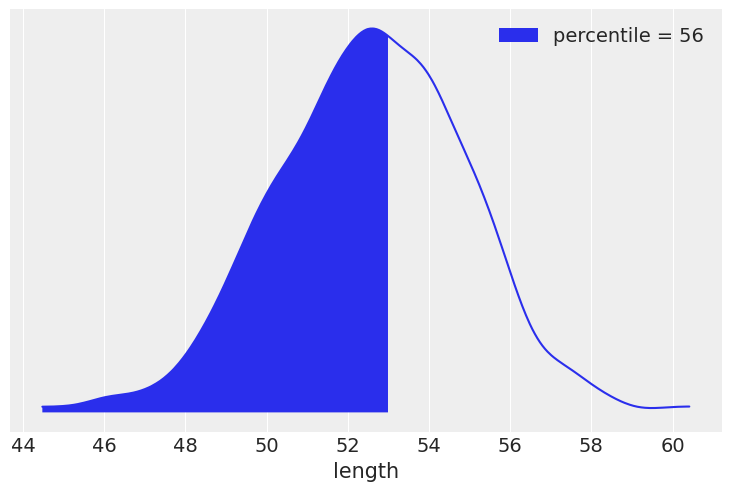

In [63]:
ref = 53
grid, pdf = az.kde(y_ppc)
plt.plot(grid, pdf)
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(grid[grid < ref],
                 pdf[grid < ref],
                 label=f'percentile = {percentile:2d}')
plt.xlabel('length')
plt.yticks([])
plt.legend()

In [64]:
x_4 = ans[ans.group == 'IV']['x'].values
y_4 = ans[ans.group == 'IV']['y'].values

with pm.Model() as model_t2:
    α = pm.Normal('α', mu=0, sd=100)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    #ν = pm.Gamma('ν', mu=20, sd=15)
    #ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_4, sd=ϵ, nu=ν, observed=y_4)
    idata_t2 = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6575546671016954, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6814485071129605, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
